In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob

%matplotlib inline

In [4]:
labels_df = pd.read_csv('../head-ct-hemorrhage/labels.csv')
labels = np.array(labels_df[' hemorrhage'].tolist())

In [5]:
files = sorted(glob.glob('D:/head-ct-hemorrhage/head_ct/head_ct/*.png'))
images = np.array([cv2.imread(path) for path in files])

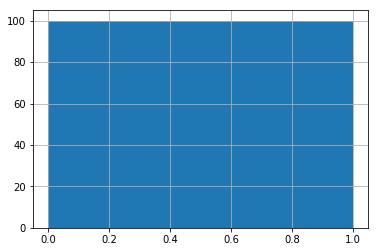

In [6]:
labels_df[' hemorrhage'].hist(bins=2)

In [11]:
labels_df[' hemorrhage'].value_counts()

1    100
0    100
Name:  hemorrhage, dtype: int64

In [15]:
images_df = pd.DataFrame(images, columns=['image'])

In [16]:
images_df['width'] = images_df['image'].apply(lambda x: x.shape[0])
images_df['height'] = images_df['image'].apply(lambda x: x.shape[1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205358BF940>,
      dtype=object)

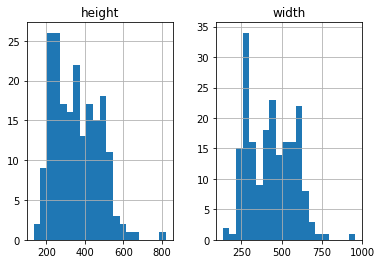

In [17]:
images_df[['height', 'width']].hist(bins=20)

In [18]:
images_df[['height', 'width']].describe()

,height,width
count,200.000000,200.000000
mean,355.505000,433.720000
std,116.785247,142.059481
min,134.000000,135.000000
25%,252.000000,298.750000
50%,345.000000,435.500000
75%,447.250000,554.000000
max,821.000000,957.000000


In [19]:
images = np.array([cv2.resize(image, (128, 128)) for image in images])

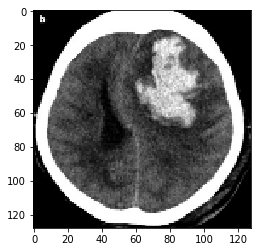

In [20]:
plt.imshow(images[0])

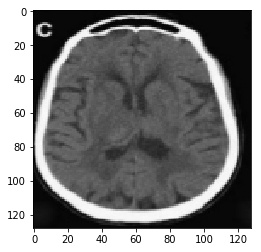

In [21]:
plt.imshow(images[100])

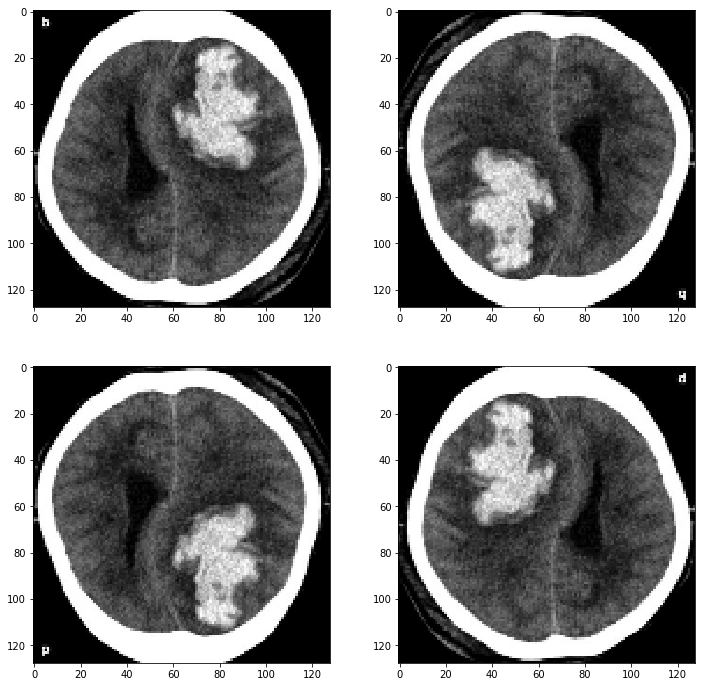

In [22]:
plt.figure(figsize=(12, 12))
for i, flip in enumerate([None, -1, 0, 1]):
    plt.subplot(221 + i)
    if flip is None:
        plt.imshow(images[0])
    else:
        plt.imshow(cv2.flip(images[0], flip))

In [23]:
# since data is strictly true until index 100 and then strictly false,
# we can take random 90 entries from frist half and then random 90 from the second half
# to have evenly distributed train and test sets
indicies = np.random.permutation(100)
train_true_idx, test_true_idx = indicies[:90], indicies[90:]
train_false_idx, test_false_idx = indicies[:90] + 100, indicies[90:] + 100
train_idx, test_idx = np.append(train_true_idx, train_false_idx), np.append(test_true_idx, test_false_idx)

train_validationX, train_validationY = images[train_idx], labels[train_idx]
testX, testY = images[test_idx], labels[test_idx]

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)


(180, 128, 128, 3) (20, 128, 128, 3)
(180,) (20,)


In [24]:
# now to split train and validation sets
tr_len = train_validationX.shape[0]
train_val_split = int(tr_len*0.9)
indicies = np.random.permutation(tr_len)
train_idx, validation_idx = indicies[:train_val_split], indicies[train_val_split:]

trainX, trainY = train_validationX[train_idx], train_validationY[train_idx]
validationX, validationY = train_validationX[validation_idx], train_validationY[validation_idx]

print(trainX.shape, validationX.shape)
print(trainY.shape, validationY.shape)

(162, 128, 128, 3) (18, 128, 128, 3)
(162,) (18,)


In [32]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import math

In [33]:
train_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)
validation_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0)

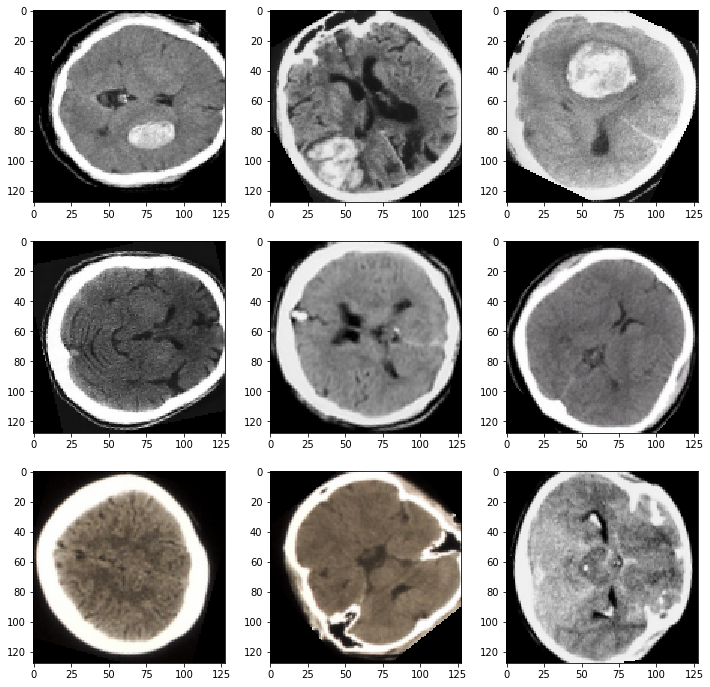

In [34]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

In [35]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
        
    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%")
    return (tn, fp, fn, tp)

In [36]:
def simple_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [37]:
model = simple_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

In [39]:
model.fit_generator(train_image_data.flow(trainX, trainY, batch_size=128),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint("weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=16)

Epoch 1/16
128/128 [==============================] - 341s 3s/step - loss: 0.6696 - acc: 0.5856 - val_loss: 0.7149 - val_acc: 0.4722
Epoch 2/16
128/128 [==============================] - 44s 342ms/step - loss: 0.6131 - acc: 0.6666 - val_loss: 0.5640 - val_acc: 0.6889
Epoch 3/16
128/128 [==============================] - 45s 355ms/step - loss: 0.5896 - acc: 0.6851 - val_loss: 0.6173 - val_acc: 0.6322
Epoch 4/16
128/128 [==============================] - 45s 351ms/step - loss: 0.5668 - acc: 0.7036 - val_loss: 0.6442 - val_acc: 0.6256
Epoch 5/16
128/128 [==============================] - 45s 351ms/step - loss: 0.5359 - acc: 0.7338 - val_loss: 0.5647 - val_acc: 0.6744
Epoch 6/16
128/128 [==============================] - 44s 345ms/step - loss: 0.5083 - acc: 0.7525 - val_loss: 0.4370 - val_acc: 0.7800
Epoch 7/16
128/128 [==============================] - 40s 313ms/step - loss: 0.4808 - acc: 0.7890 - val_loss: 0.6770 - val_acc: 0.5778
Epoch 8/16
128/128 [==============================] - 39s

True positive: 10 , True negative: 6 , False positive: 1 , False negative: 1
Total accuracy: 88.88888888888889 %


(6, 1, 1, 10)

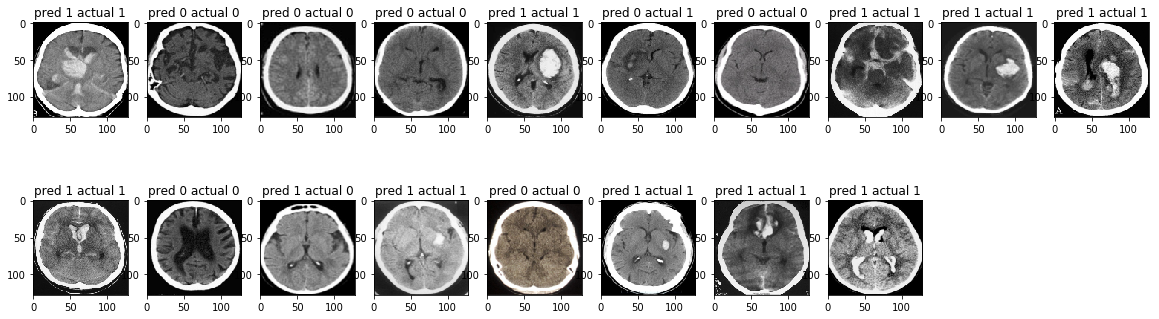

In [40]:
check_accuracy(model, validationX/255., validationY)

In [41]:
model.save("last-weights.h5")
model.load_weights("weights.h5")

In [42]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 78 , True negative: 58 , False positive: 25 , False negative: 1
Total accuracy: 83.9506172839506 %


(58, 25, 1, 78)

True positive: 11 , True negative: 5 , False positive: 2 , False negative: 0
Total accuracy: 88.88888888888889 %


(5, 2, 0, 11)

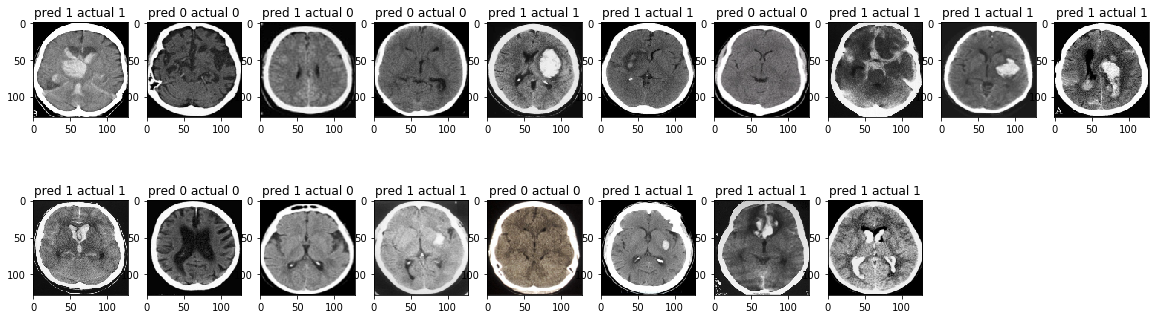

In [43]:
check_accuracy(model, validationX/255., validationY)

In [44]:
def imbalance_set(coeff=2):
    imbalanced_trainX = []
    imbalanced_trainY = []
    for i, train_x in enumerate(trainX):
        def add_entry(x, y):
            imbalanced_trainX.append(x)
            imbalanced_trainY.append(y)

        add_entry(train_x, trainY[i])

        if(trainY[i] == 1):
            for j in range(coeff-1):
                add_entry(train_x, trainY[i])
    return (np.array(imbalanced_trainX), np.array(imbalanced_trainY))

imbalanced_trainX, imbalanced_trainY = imbalance_set(2)
print(imbalanced_trainX.shape, imbalanced_trainY.shape)

(241, 128, 128, 3) (241,)


In [45]:
def bigger_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [46]:
model = bigger_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
__________

In [47]:
model.fit(imbalanced_trainX, imbalanced_trainY, validation_data=(validationX, validationY),
          callbacks=[ModelCheckpoint("weights-fna-model.hdf5", monitor='val_acc', save_best_only=True, mode='max')],
          batch_size=128, epochs=200)

Train on 241 samples, validate on 18 samples
Epoch 1/200
241/241 [==============================] - 1s 4ms/step - loss: 4.8799 - acc: 0.5187 - val_loss: 6.1998 - val_acc: 0.6111
Epoch 2/200
241/241 [==============================] - 0s 1ms/step - loss: 4.1827 - acc: 0.6183 - val_loss: 0.8738 - val_acc: 0.2778
Epoch 3/200
241/241 [==============================] - 0s 1ms/step - loss: 1.5224 - acc: 0.6017 - val_loss: 0.6497 - val_acc: 0.6667
Epoch 4/200
241/241 [==============================] - 0s 1ms/step - loss: 0.7551 - acc: 0.5353 - val_loss: 0.5982 - val_acc: 0.6111
Epoch 5/200
241/241 [==============================] - 0s 1ms/step - loss: 0.7506 - acc: 0.5892 - val_loss: 0.6408 - val_acc: 0.6667
Epoch 6/200
241/241 [==============================] - 0s 1ms/step - loss: 0.7167 - acc: 0.5602 - val_loss: 0.6310 - val_acc: 0.6667
Epoch 7/200
241/241 [==============================] - 0s 1ms/step - loss: 0.6667 - acc: 0.6473 - val_loss: 0.6279 - val_acc: 0.7222
Epoch 8/200
241/241 [===

Epoch 62/200
241/241 [==============================] - 0s 1ms/step - loss: 0.2499 - acc: 0.9253 - val_loss: 0.4806 - val_acc: 0.7222
Epoch 63/200
241/241 [==============================] - 0s 1ms/step - loss: 0.1646 - acc: 0.9378 - val_loss: 0.4958 - val_acc: 0.7222
Epoch 64/200
241/241 [==============================] - 0s 1ms/step - loss: 0.2206 - acc: 0.9212 - val_loss: 0.6118 - val_acc: 0.7222
Epoch 65/200
241/241 [==============================] - 0s 1ms/step - loss: 0.1671 - acc: 0.9461 - val_loss: 0.4897 - val_acc: 0.7222
Epoch 66/200
241/241 [==============================] - 0s 1ms/step - loss: 0.1298 - acc: 0.9627 - val_loss: 0.5977 - val_acc: 0.7778
Epoch 67/200
241/241 [==============================] - 0s 1ms/step - loss: 0.1215 - acc: 0.9544 - val_loss: 0.6662 - val_acc: 0.7222
Epoch 68/200
241/241 [==============================] - 0s 1ms/step - loss: 0.1038 - acc: 0.9710 - val_loss: 0.4611 - val_acc: 0.7778
Epoch 69/200
241/241 [==============================] - 0s 1ms

Epoch 123/200
241/241 [==============================] - 0s 1ms/step - loss: 0.2111 - acc: 0.9129 - val_loss: 1.0394 - val_acc: 0.6111
Epoch 124/200
241/241 [==============================] - 0s 1ms/step - loss: 0.0203 - acc: 0.9917 - val_loss: 1.0950 - val_acc: 0.6111
Epoch 125/200
241/241 [==============================] - 0s 1ms/step - loss: 0.0173 - acc: 1.0000 - val_loss: 1.1669 - val_acc: 0.6111
Epoch 126/200
241/241 [==============================] - 0s 1ms/step - loss: 0.0163 - acc: 1.0000 - val_loss: 1.1971 - val_acc: 0.6667
Epoch 127/200
241/241 [==============================] - 0s 1ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 1.2009 - val_acc: 0.6667
Epoch 128/200
241/241 [==============================] - 0s 1ms/step - loss: 0.0134 - acc: 0.9959 - val_loss: 1.3048 - val_acc: 0.6667
Epoch 129/200
241/241 [==============================] - 0s 1ms/step - loss: 0.0142 - acc: 0.9959 - val_loss: 1.2418 - val_acc: 0.6667
Epoch 130/200
241/241 [==============================] 

In [48]:
model.fit_generator(train_image_data.flow(imbalanced_trainX, imbalanced_trainY, batch_size=128),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint("bigger_model_checkpoint_weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=24)

Epoch 1/24
128/128 [==============================] - 61s 475ms/step - loss: 0.6275 - acc: 0.6681 - val_loss: 0.6288 - val_acc: 0.6544
Epoch 2/24
128/128 [==============================] - 58s 453ms/step - loss: 0.5803 - acc: 0.7073 - val_loss: 0.5877 - val_acc: 0.6378
Epoch 3/24
128/128 [==============================] - 58s 454ms/step - loss: 0.5469 - acc: 0.7271 - val_loss: 0.5320 - val_acc: 0.7067
Epoch 4/24
128/128 [==============================] - 58s 457ms/step - loss: 0.5251 - acc: 0.7407 - val_loss: 0.5233 - val_acc: 0.7389
Epoch 5/24
128/128 [==============================] - 58s 453ms/step - loss: 0.4983 - acc: 0.7580 - val_loss: 0.5556 - val_acc: 0.7222
Epoch 6/24
128/128 [==============================] - 58s 454ms/step - loss: 0.4672 - acc: 0.7721 - val_loss: 0.4269 - val_acc: 0.8167
Epoch 7/24
128/128 [==============================] - 58s 455ms/step - loss: 0.4427 - acc: 0.8001 - val_loss: 0.3785 - val_acc: 0.8667
Epoch 8/24
128/128 [==============================] - 5

In [49]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 79 , True negative: 77 , False positive: 6 , False negative: 0
Total accuracy: 96.29629629629629 %


(77, 6, 0, 79)

In [50]:
check_accuracy(model, validationX/255., validationY, False)

True positive: 11 , True negative: 5 , False positive: 2 , False negative: 0
Total accuracy: 88.88888888888889 %


(5, 2, 0, 11)

In [51]:
model.save("bigger_model_latest_weights.h5")
model.load_weights("bigger_model_checkpoint_weights.h5")

In [52]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 78 , True negative: 75 , False positive: 8 , False negative: 1
Total accuracy: 94.44444444444444 %


(75, 8, 1, 78)

In [53]:
check_accuracy(model, validationX/255., validationY, False)

True positive: 10 , True negative: 5 , False positive: 2 , False negative: 1
Total accuracy: 83.33333333333334 %


(5, 2, 1, 10)

True positive: 10 , True negative: 8 , False positive: 2 , False negative: 0
Total accuracy: 90.0 %


(8, 2, 0, 10)

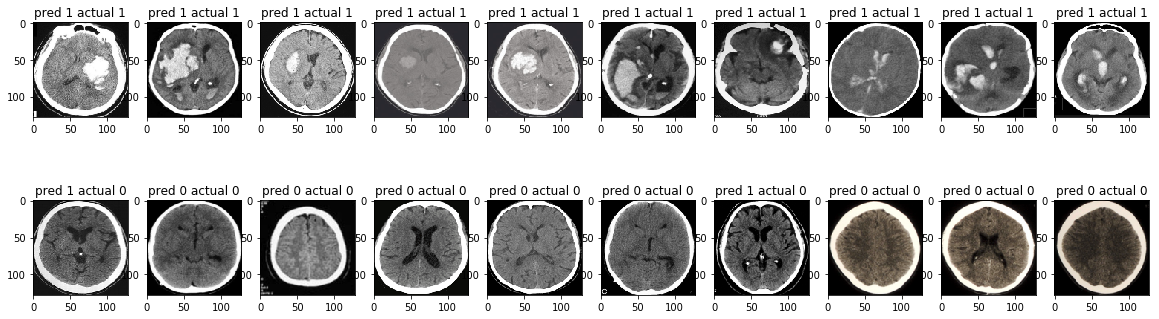

In [54]:
check_accuracy(model, testX/255., testY)